In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import os
import matplotlib.pyplot as plt



num_of_clusters = 16

ToolName = 'scanpy' 
DatasetName = 'PBMC1'
Data_path = '../../dataset/{}-Filtered/10X/'.format(DatasetName)
save_path = '../../results/{}/{}/'.format(DatasetName, ToolName)

if not os.path.exists(save_path):
    os.makedirs(save_path)


# for white background of figures (only for docs rendering)
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

In [2]:
adata = sc.read_10x_mtx(
    Data_path,  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=False
)

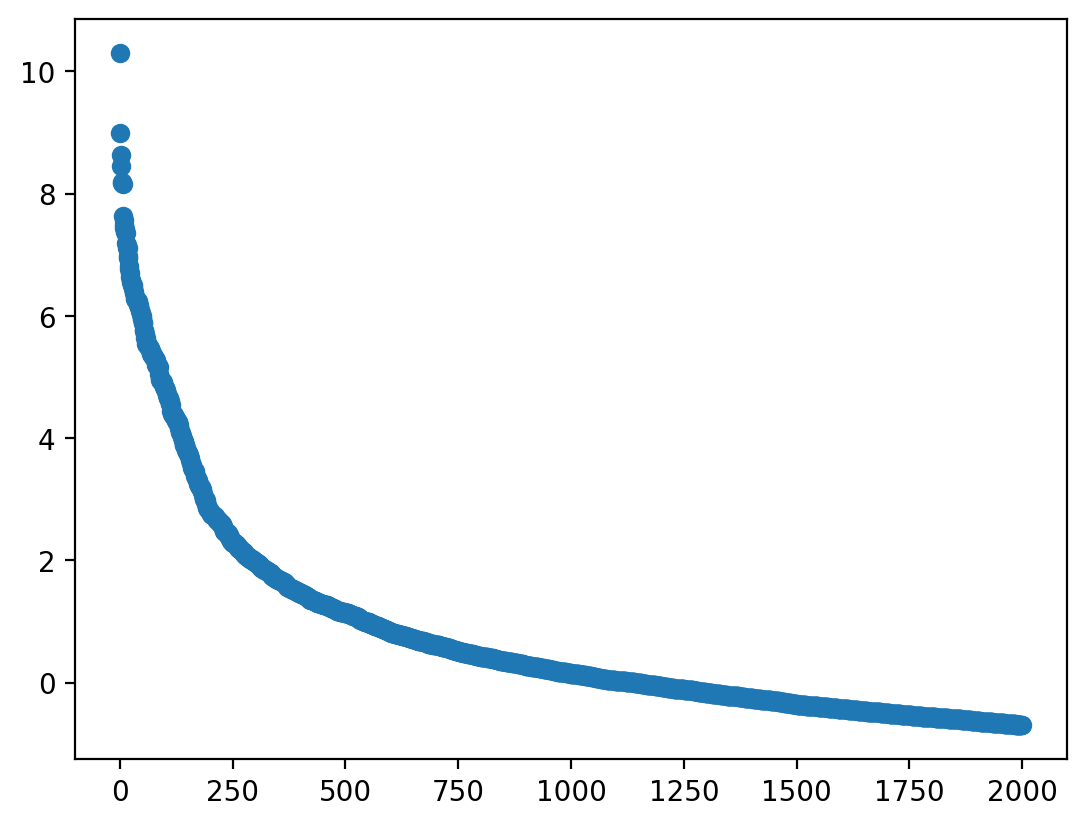

In [3]:
matrix = adata.X
# from sparse matrix to dense matrix
matrix = matrix.todense()
# find the most variable features (columns) of the matrix sorted by variance
variances = np.sort(-np.var(matrix, axis=0))
sorted_array = [np.log(-i) for i in variances.T][:2000]
# plot the variance of the features
plt.scatter([i for i in range(len(sorted_array))], sorted_array)

In [4]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [5]:
sc.pp.highly_variable_genes(adata, n_top_genes=500, flavor='seurat_v3') # seurat FindVariableFeatures

/Users/irenetesta/anaconda3/envs/chl/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:61: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


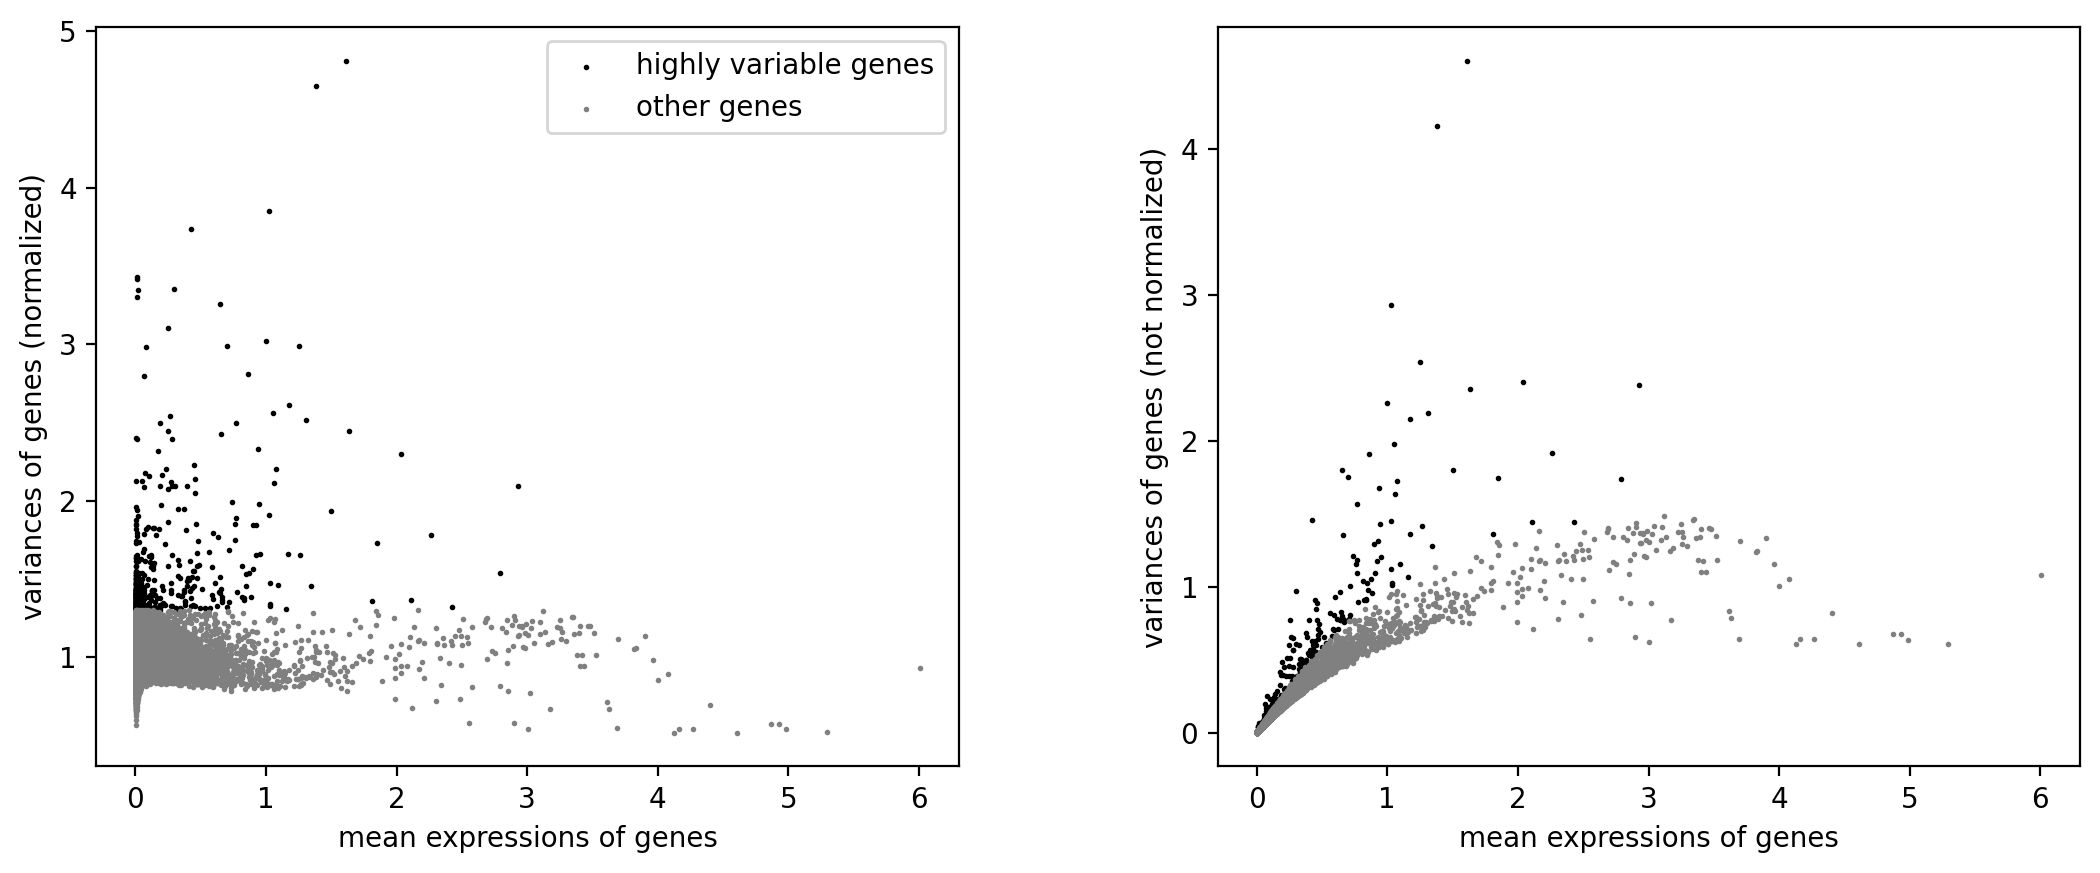

In [6]:
sc.pl.highly_variable_genes(adata)

In [7]:
sc.pp.scale(adata)

/Users/irenetesta/anaconda3/envs/chl/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


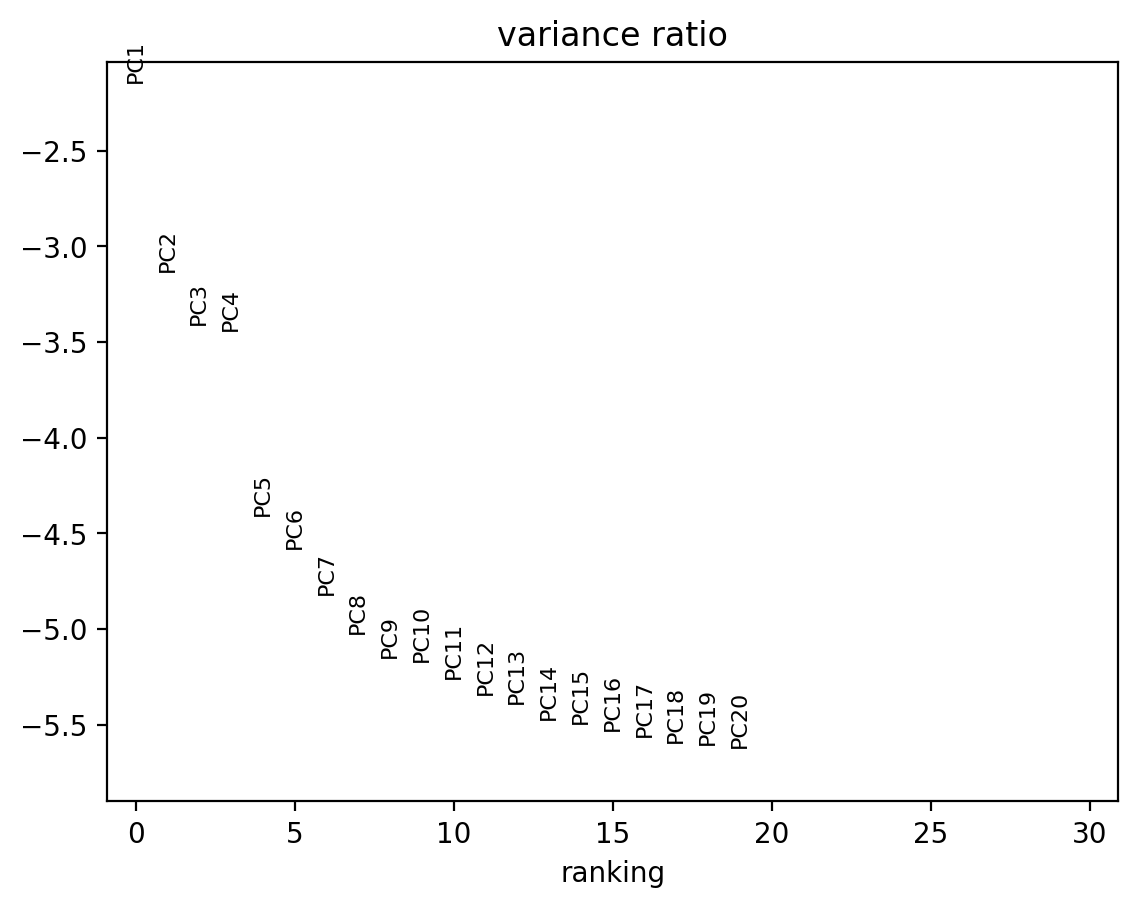

In [8]:
sc.tl.pca(adata, svd_solver='arpack', n_comps=20, use_highly_variable=True)
sc.pl.pca_variance_ratio(adata, log=True)

/Users/irenetesta/anaconda3/envs/chl/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/irenetesta/anaconda3/envs/chl/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/irenetesta/anaconda3/envs/chl/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/irenetesta/anaconda3/envs/chl/

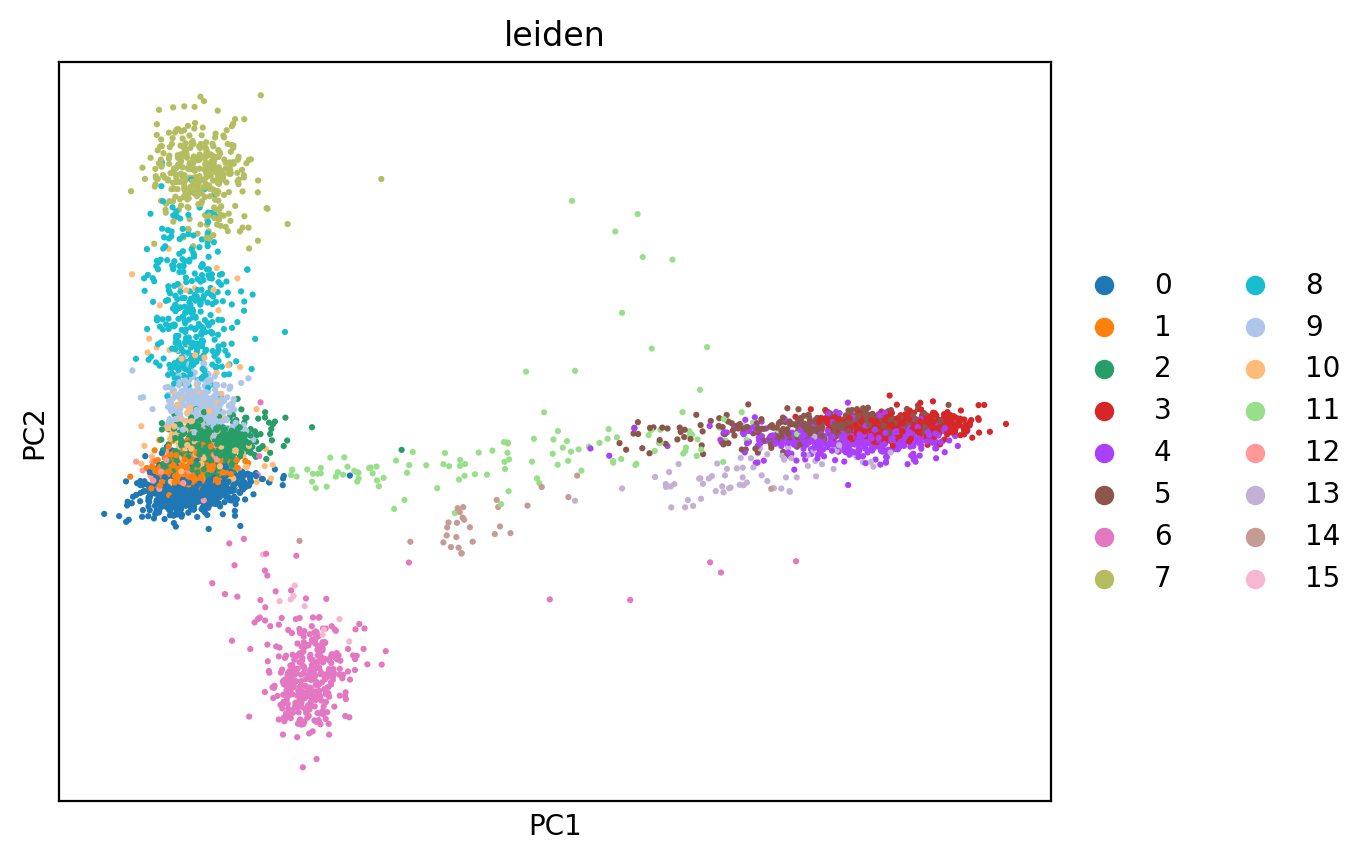

In [9]:
sc.pp.neighbors(adata, n_neighbors=20, n_pcs=8)

res = 0.000
sc.tl.leiden(adata, resolution=res)
while not (adata.obs.leiden.values.categories.values).shape == (num_of_clusters, ) or res == 1.0:
    res += 0.005
    sc.tl.leiden(adata, resolution=res)
    
sc.pl.pca(adata, color=['leiden'], size=20)

In [10]:
# cluster id for each cell renamed as cluster

df = pd.DataFrame(adata.obs['leiden'])

labels = df.rename(columns={'leiden': 'cluster'})
labels.index.name = 'cell'

labels['cluster'] = labels['cluster'].astype(int) + 1

labels.to_csv(f'{save_path}/clustering_labels.csv', index=True)

In [11]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon') 

/Users/irenetesta/anaconda3/envs/chl/lib/python3.11/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/Users/irenetesta/anaconda3/envs/chl/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/irenetesta/anaconda3/envs/chl/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/irenetesta/anaconda3/envs/chl/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/iren

In [12]:
test=adata.uns['rank_genes_groups']
test

{'params': {'groupby': 'leiden',
  'reference': 'rest',
  'method': 'wilcoxon',
  'use_raw': False,
  'layer': None,
  'corr_method': 'benjamini-hochberg'},
 'names': rec.array([('MT-ATP6', 'RPS3A', 'RPS18', 'LYZ', 'AIF1', 'S100A8', 'MS4A1', 'GNLY', 'CCL5', 'IL32', 'MALAT1', 'MT-ND2', 'MALAT1', 'HLA-DRB1', 'IRF8', 'CLU'),
            ('MT-CYB', 'RPL30', 'RPS12', 'MNDA', 'CST3', 'S100A9', 'CD79A', 'NKG7', 'NKG7', 'GZMK', 'MT-CO1', 'MT-ND1', 'RPL11', 'HLA-DRA', 'LILRA4', 'NRGN'),
            ('MT-CO3', 'RPL9', 'TPT1', 'S100A9', 'COTL1', 'S100A6', 'CD79B', 'PRF1', 'GZMA', 'IL7R', 'MT-ND5', 'MT-CO1', 'TCF7', 'HLA-DPB1', 'CCDC50', 'PPBP'),
            ...,
            ('EEF1A1', 'MT-CO2', 'PLEK', 'MT-ATP6', 'ACAP1', 'RPL3', 'HCST', 'MT-ND2', 'NCF1', 'C1orf162', 'TPT1', 'RPL12', 'CD74', 'MALAT1', 'MT-CO3', 'JUN'),
            ('RPLP1', 'MT-ND1', 'ZEB2', 'MT-CYB', 'BTG1', 'SRSF7', 'GIMAP7', 'MT-ND1', 'AIF1', 'HLA-DRA', 'RPS14', 'RPS2', 'HLA-B', 'MT-ND3', 'KLF2', 'JUND'),
            ('TMSB4X'

In [13]:
number_of_genes = 500

names = adata.uns['rank_genes_groups']['names'][:number_of_genes]
# transform each element of names in a list
names = [list(x) for x in names]

df = pd.DataFrame(columns=['gene', 'cluster', 'rank'])

for i in range(num_of_clusters):
    to_add = [ [names[j][i], i, j] for j in range(number_of_genes)]
    to_add = pd.DataFrame(to_add, columns=['gene', 'cluster', 'rank'])
    df = pd.concat([df, to_add],  ignore_index=True)


df['cluster'] = df['cluster'].astype(int) + 1
df['rank'] = df['rank'].astype(int) + 1

df.to_csv(f'{save_path}/markers.csv', index=False)